In [1]:
!pip install -q pandas scikit-learn matplotlib joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

import joblib
np.random.seed(42)


In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)  # load dataset as a dataframe
df = data.frame  # put it into a table form
print(df.shape)  # show rows and columns
df.head()  # show the first 5 rows


(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
from sklearn.model_selection import train_test_split

X = data.data      # features (all columns except target)
y = data.target    # target (malignant or benign)

# split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 455
Test size: 114


Accuracy: 0.9825
F1: 0.9861
ROC-AUC: 0.9954
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



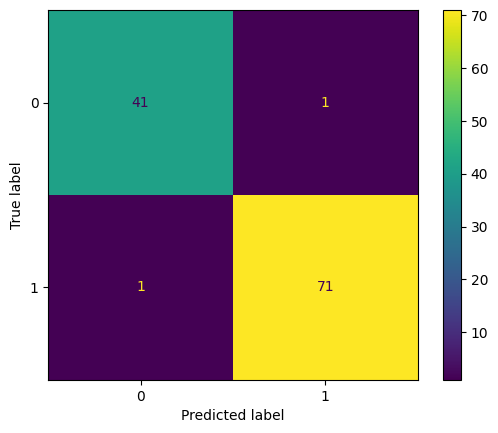

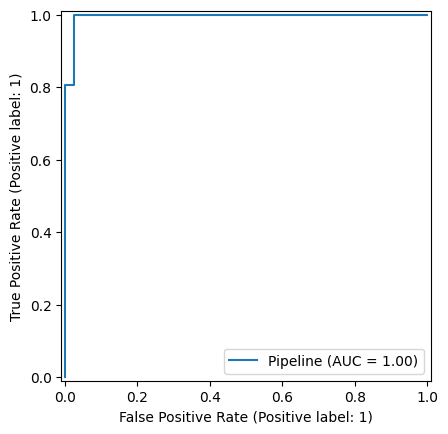

In [5]:
# Import tools for pipeline, preprocessing, model, and evaluation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Build a pipeline:
# 1. Handle missing values (impute with median)
# 2. Scale features (StandardScaler)
# 3. Train Logistic Regression model
pipe_lr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),   # fill missing values with median
    ("sc", StandardScaler()),                   # scale features to mean 0, std 1
    ("clf", LogisticRegression(max_iter=500))   # classifier: logistic regression
])

# Fit (train) the pipeline on the training data
pipe_lr.fit(X_train, y_train)

# Make predictions on the test set
pred = pipe_lr.predict(X_test)                # predicted classes (0 or 1)
proba = pipe_lr.predict_proba(X_test)[:, 1]   # predicted probabilities for class 1

# Print evaluation scores
print("Accuracy:", round(accuracy_score(y_test, pred), 4))   # overall % correct
print("F1:", round(f1_score(y_test, pred), 4))               # balance of precision/recall
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))    # how well it separates classes
print(classification_report(y_test, pred, target_names=data.target_names))

# Plot confusion matrix (shows counts of correct/incorrect predictions)
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.show()

# Plot ROC curve (shows tradeoff between true positive and false positive rates)
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.show()


RF Accuracy: 0.9474
RF F1: 0.9583
RF ROC-AUC: 0.9937


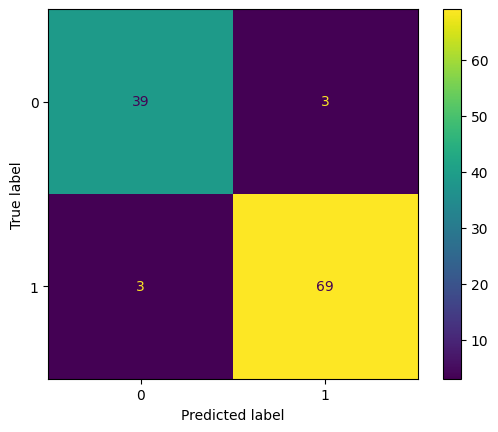

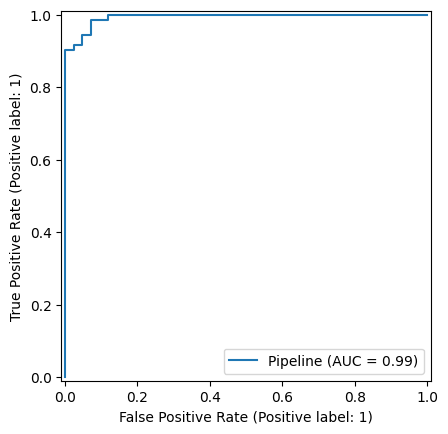

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# pipeline: impute -> scale -> random forest
pipe_rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=False)),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ))
])

pipe_rf.fit(X_train, y_train)

pred_rf = pipe_rf.predict(X_test)
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("RF Accuracy:", round(accuracy_score(y_test, pred_rf), 4))
print("RF F1:", round(f1_score(y_test, pred_rf), 4))
print("RF ROC-AUC:", round(roc_auc_score(y_test, proba_rf), 4))

ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test)
plt.show()
RocCurveDisplay.from_estimator(pipe_rf, X_test, y_test)
plt.show()


In [7]:
import pandas as pd

metrics = pd.DataFrame({
    "model": ["LogReg", "RandForest"],
    "accuracy": [
        accuracy_score(y_test, pred),
        accuracy_score(y_test, pred_rf)
    ],
    "f1": [
        f1_score(y_test, pred),
        f1_score(y_test, pred_rf)
    ],
    "roc_auc": [
        roc_auc_score(y_test, proba),
        roc_auc_score(y_test, proba_rf)
    ],
})
metrics


,model,accuracy,f1,roc_auc
0,LogReg,0.982456,0.986111,0.995370
1,RandForest,0.947368,0.958333,0.993717


In [8]:
from sklearn.inspection import permutation_importance
import numpy as np

r = permutation_importance(pipe_rf, X_test, y_test, n_repeats=10, random_state=42)
idx = np.argsort(r.importances_mean)[::-1][:10]

print("Top features:")
for i in idx:
    print(f"{X.columns[i]}  mean_imp={r.importances_mean[i]:.4f}")


Top features:
mean concave points  mean_imp=0.0026
worst fractal dimension  mean_imp=0.0000
fractal dimension error  mean_imp=0.0000
symmetry error  mean_imp=0.0000
concave points error  mean_imp=0.0000
concavity error  mean_imp=0.0000
radius error  mean_imp=0.0000
mean fractal dimension  mean_imp=0.0000
mean radius  mean_imp=0.0000
mean area  mean_imp=0.0000


In [9]:
import numpy as np

mis_idx = np.where(pred_rf != y_test)[0]
print("Misclassified count:", len(mis_idx))
print("Indices:", mis_idx[:10])
# optional: inspect first mistake row
X_test.iloc[mis_idx[:1]]


Misclassified count: 6
Indices: [ 3 16 25 35 53 65]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
363,16.5,18.29,106.6,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,18.13,25.45,117.2,1009.0,0.1338,0.1679,0.1663,0.09123,0.2394,0.06469


In [10]:
import joblib
joblib.dump(pipe_rf, "breast_cancer_rf.joblib")


['breast_cancer_rf.joblib']

In [11]:
sample = X_test.iloc[[0]]
print("Pred class:", pipe_rf.predict(sample)[0])          # 0 = malignant, 1 = benign
print("Prob benign:", round(pipe_rf.predict_proba(sample)[0,1], 4))


Pred class: 0
Prob benign: 0.0


In [12]:
from sklearn.metrics import confusion_matrix

# Logistic Regression
cm_lr = confusion_matrix(y_test, pred)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
print("LR confusion:", cm_lr, " | FP:", fp_lr, "FN:", fn_lr)

# Random Forest
cm_rf = confusion_matrix(y_test, pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
print("RF confusion:", cm_rf, " | FP:", fp_rf, "FN:", fn_rf)


LR confusion: [[41  1]
 [ 1 71]]  | FP: 1 FN: 1
RF confusion: [[39  3]
 [ 3 69]]  | FP: 3 FN: 3


In [13]:
from sklearn.inspection import permutation_importance
import numpy as np

r_lr = permutation_importance(pipe_lr, X_test, y_test,
                              n_repeats=30, random_state=42, scoring="roc_auc")
idx = np.argsort(r_lr.importances_mean)[::-1][:10]
print("LR top features (perm importance):")
for i in idx:
    print(f"{X.columns[i]}  mean_imp={r_lr.importances_mean[i]:.4f}")


LR top features (perm importance):
worst smoothness  mean_imp=0.0033
worst texture  mean_imp=0.0032
worst concave points  mean_imp=0.0030
area error  mean_imp=0.0030
radius error  mean_imp=0.0029
worst area  mean_imp=0.0027
worst radius  mean_imp=0.0027
worst concavity  mean_imp=0.0018
worst perimeter  mean_imp=0.0018
mean concave points  mean_imp=0.0016


In [14]:
from sklearn.model_selection import cross_val_score
cv_lr = cross_val_score(pipe_lr, X_train, y_train, scoring="roc_auc", cv=5, n_jobs=-1)
print("LR CV ROC-AUC mean:", round(cv_lr.mean(), 4), "std:", round(cv_lr.std(), 4))


LR CV ROC-AUC mean: 0.9935 std: 0.0108


In [15]:
import joblib
joblib.dump(pipe_lr, "breast_cancer_lr.joblib")


['breast_cancer_lr.joblib']

In [16]:
sample = X_test.iloc[[0]]
print("LR pred class:", pipe_lr.predict(sample)[0])    # 0 malignant, 1 benign
print("LR prob benign:", round(pipe_lr.predict_proba(sample)[0,1], 4))


LR pred class: 0
LR prob benign: 0.0
